### Switch from base ESN to DeepESN

**Outline**

* Since we are now able to use **additive decomposition** of timeseries into linear trend, seasonality and residual noise, as in [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper "Time series prediction using Deep Echo State Networks", we are ready to switch from base ESN to Deep ESN models.
* Therefore we need to set up an **implementation of ESN layers**, based on [tensorflow implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/ESN), able to extend to multiple ESN layer networks (= **DeepESN**).

**Sources**

* Additionally could have a look at [customized implementation](https://github.com/francesco-mannella/Echo-State-Networks) by Francesco Mannella.

#### Technical setup and data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# Read dataset SP500_1999_2019.txt, absolute values:
SP500_abs = open("../data/SP500_1999_2019.csv").read().split()
SP500_abs = np.array(SP500_abs).astype('float64')

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  676.53
train_max:  2130.82


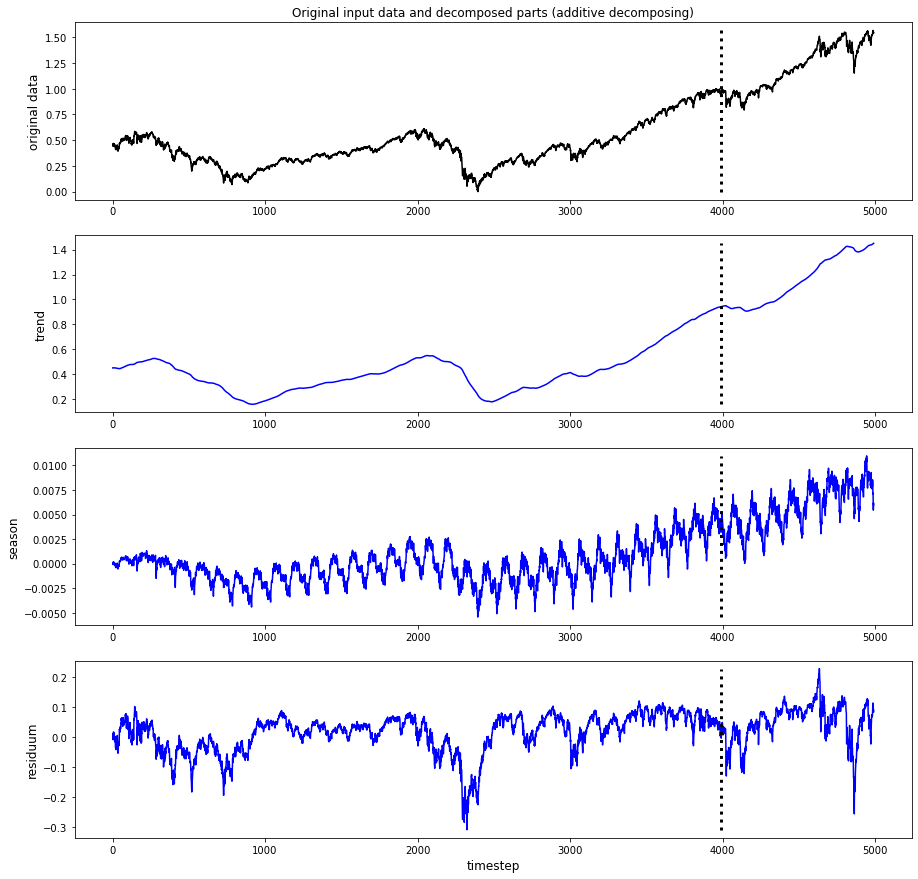


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.273522
p-value: 0.996456

Season S:
ADF Statistic: -2.016399
p-value: 0.279429

Residuum R:
ADF Statistic: -2.310809
p-value: 0.168506


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [4]:
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs,
                                                                                         input_length=10,
                                                                                         target_length=1,
                                                                                         train_val_split=0.8,
                                                                                         alpha=0.01,
                                                                                         gamma=0.01,
                                                                                         s=125,
                                                                                         scaled_YN=True,
                                                                                         verbose=True)

In [1]:
## Define function "decompose_split":
# First step is additive decomposing given time series of absolute values into trend, seasonality and residual noise.
# Second step is splitting the original series plus obtained series from decomposition into samples of desired
# input length. Then create targets from specified target length and split data into training and validation sets.
#
# Additional input parameters for decomposing: 
# Smoothing parameters alpha and gamma plus length of season s.
# scaled_YN (True/False):if True, scale input_series to [0,1] applying min/max scaling before decomposing.
# 
# Additional input parameters for splitting: 
# input length, target length and train_val_split to specify the relative amount of samples used for training.

def decompose_split(input_series, input_length, target_length, train_val_split,
                    alpha, gamma, s, scaled_YN=False, verbose=False):
    
    ## First step: Decomposing given input series.
    
    # Get length T of input series:
    T = len(input_series)
     
    # Initialize arrays for storing trend L, seasonality S and residual noise R:
    L = np.zeros(T)
    S = np.zeros(T)
    R = np.zeros(T)
    
    # Optionally scale input series to [0,1] with min/max scaling.
    # Note: Get min/max only from train inputs, pretending to not know validation data, yet.
    # Initialize input_min and _max to zero, to have return values even if no scaling is desired.
    train_min = 0
    train_max = 0
    if scaled_YN:
        train_min = np.min(input_series[:int(T * train_val_split)])
        train_max = np.max(input_series[:int(T * train_val_split)])
        
        # substract min and divide by (max - min)
        input_series = (input_series - train_min) / (train_max - train_min)
    
    # First step (t=0) needs special treatment, since we don't have L(t-1):
    L[0] = input_series[0]
    S[0] = 0
    R[0] = 0
    
    # Loop over input series and calculate trend, seasonality and residual noise.
    # Note: Start at 1, since step (t=0) is already taken care of.
    for t in range(1, T):
        
        # First s timesteps need special treatment, since we don't have S(t-s) for these steps:
        if t < s:
            L[t] = alpha * input_series[t] + (1 - alpha) * L[t-1]
            S[t] = gamma * (input_series[t] - L[t])
            R[t] = input_series[t] - L[t] - S[t]
        else:
            L[t] = alpha * (input_series[t] - S[t-s]) + (1 - alpha) * L[t-1]
            S[t] = gamma * (input_series[t] - L[t]) + (1 - gamma) * S[t-s]
            R[t] = input_series[t] - L[t] - S[t]
    
    # Reshape input_series, L, S and R to have feature as second dimensios: New shape (T, 1).
    input_series = input_series.reshape((T,1))
    L = L.reshape((T,1))
    S = S.reshape((T,1))
    R = R.reshape((T,1))
    
    # Get min/max for scaled input series, L, S and R for plotting vertical barrier separating train and val data:
    input_series_min = np.min(input_series)
    input_series_max = np.max(input_series)
    L_min = np.min(L)
    L_max = np.max(L)
    S_min = np.min(S)
    S_max = np.max(S)
    R_min = np.min(R)
    R_max = np.max(R)
        
    # Concatenate input_series, L, S and R to have ONE series with 4 features, shape (T, 4).
    data = np.concatenate((input_series, L, S, R), axis=-1)
    
    ## Second step: Splitting data (consisting of input_series and decomposed parts L, S, R).
    
    # Split data according to desired input_length, save series in list X.
    # End up with (len(data) - input_length + 1) samples.
    X = list()
    for i in range(len(data) - input_length + 1):
        sample = data[i:i+input_length]
        X.append(sample)
    
    # Convert X to np.array.
    X = np.array(X)
    
    # Cut the last target_length samples to make sure, we have a target for each input sample.
    X = X[:-target_length]
    
    # Create targets from original input series, store in Y.
    Y = input_series[target_length:]
    
    # Cut the first (input_length - 1) targets, since we don't have input samples for these targets.
    Y = Y[input_length-1:]
    
    # Split inputs and targets into train and validation data according to train_val_split
    n_train = int(len(X) * train_val_split)

    train_input = X[:n_train]
    val_input = X[n_train:]
    train_target = Y[:n_train]
    val_target = Y[n_train:]

    # Optionally print dimensions and plot (optionally) scaled original series plus decomposed parts.
    if verbose:
        print("original input series shape: ", input_series.shape)
        print("train_input shape: ", train_input.shape)
        print("val_input shape: ", val_input.shape)
        print("train_target shape: ", train_target.shape)
        print("val_target shape: ", val_target.shape)
        print("train_min: ", train_min)
        print("train_max: ", train_max)
        
        # Plot original timeseries, together with decomposed parts: Trend L, seasonality S and residual noise R.
        # Note: Concatenate train and validation input, shape (samples, timesteps, features).
        #       Take last timestep for each sample and all features seperately.
        fig, axes = plt.subplots(4, 1, figsize=(15,15))
        axes[0].plot(range(1, T-input_length+1),
                     np.concatenate((train_input[:,-1,0],val_input[:,-1,0])), color="k", label="original data")  
        axes[1].plot(range(1, T-input_length+1),
                     np.concatenate((train_input[:,-1,1],val_input[:,-1,1])), color="b", label="Trend")
        axes[2].plot(range(1, T-input_length+1),
                     np.concatenate((train_input[:,-1,2],val_input[:,-1,2])), color="b", label="Seasonality")
        axes[3].plot(range(1, T-input_length+1),
                     np.concatenate((train_input[:,-1,3],val_input[:,-1,3])), color="b", label="Residuum")
        axes[3].set_xlabel("timestep", fontsize=12)
        axes[0].set_ylabel("original data", fontsize=12)
        axes[1].set_ylabel("trend", fontsize=12)
        axes[2].set_ylabel("season", fontsize=12)
        axes[3].set_ylabel("residuum", fontsize=12)
        axes[0].set_title("Original input data and decomposed parts (additive decomposing)")
        
        # Include vertical barriers separating train and validation data.
        axes[0].plot([n_train,n_train],[input_series_min+np.spacing(1),input_series_max-np.spacing(1)],'k:', linewidth=3)
        axes[1].plot([n_train,n_train],[L_min+np.spacing(1),L_max-np.spacing(1)],'k:', linewidth=3)
        axes[2].plot([n_train,n_train],[S_min+np.spacing(1),S_max-np.spacing(1)],'k:', linewidth=3)
        axes[3].plot([n_train,n_train],[R_min+np.spacing(1),R_max-np.spacing(1)],'k:', linewidth=3)

        plt.show()
        
        # Now apply augmented Dickey Fuller test (ADFT) to optionally scaled original input series and 
        # results from decomposition: Trend, seasonality and residuum.
        # Note: Concatenate train and validation input, shape (samples, timesteps, features).
        #       Take last timestep for each sample and all features seperately.
        ADFT_orig = adfuller(np.concatenate((train_input[:,-1,0],val_input[:,-1,0])))
        ADFT_L = adfuller(np.concatenate((train_input[:,-1,0],val_input[:,-1,1])))
        ADFT_S = adfuller(np.concatenate((train_input[:,-1,0],val_input[:,-1,2])))
        ADFT_R = adfuller(np.concatenate((train_input[:,-1,0],val_input[:,-1,3])))

        # Print results from ADFT:
        print('\noriginal:')
        print('=========')
        print('ADF Statistic: %f' % ADFT_orig[0])
        print('p-value: %f' % ADFT_orig[1])
        
        print('\nTrend L:')
        print('========')
        print('ADF Statistic: %f' % ADFT_L[0])
        print('p-value: %f' % ADFT_L[1])
        
        print('\nSeason S:')
        print('=========')
        print('ADF Statistic: %f' % ADFT_S[0])
        print('p-value: %f' % ADFT_S[1])
        
        print('\nResiduum R:')
        print('===========')
        print('ADF Statistic: %f' % ADFT_R[0])
        print('p-value: %f' % ADFT_R[1])
        print('\n\nCritical Values:')
        for key, value in ADFT_R[4].items():
            print('\t%s: %.3f' % (key, value))

    # Return values:
    # train_input and val_input contain original input series, trend L, seasonality S and residual noise R.
    # train_target and val_target contain targets from original input series.
    return train_input, val_input, train_target, val_target, train_min, train_max        

In [3]:
## Define function to perform gridsearch on smoothing parameters alpha and beta, plus run series of cycle length s.
#
# Optionally scale input series of absolute values to [0,1] applying min/max scaling before decomposing.
# 
# Additional input parameters for decomposing: 
# Smoothing parameters alpha and gamma running from given _min to _max value in given number of _steps.
# Store p-value from augmented Dickey Fuller test (ADFT) for as heatmap (alpha-gamma-grid) for 
# original input_series, L, S and R seperately.
# Create heatmaps for all cycle lengths from _min to _max in given number of _steps.
# scaled_YN (True/False):if True, scale input_series to [0,1] applying min/max scaling before decomposing.

def decompose_gridsearch(input_series,
                         alpha_min, alpha_max, alpha_steps,
                         gamma_min, gamma_max, gamma_steps,
                         s_min, s_max, s_steps,
                         scaled_YN=False, verbose=False):
    
    ## First step: Decomposing given input series.
    
    # Get length T of input series:
    T = len(input_series)
     
    # Initialize arrays for storing trend L, seasonality S and residual noise R:
    L = np.zeros(T)
    S = np.zeros(T)
    R = np.zeros(T)
    
    # Optionally scale input series to [0,1] with min/max scaling.
    # Note: Get min/max only from train inputs, pretending to not know validation data, yet.
    # Initialize input_min and _max to zero, to have return values even if no scaling is desired.
    input_series_min = 0
    input_series_max = 0
    if scaled_YN:
        input_series_min = np.min(input_series)
        input_series_max = np.max(input_series)
        
        # substract min and divide by (max - min)
        input_series = (input_series - input_series_min) / (input_series_max - input_series_min)
    
    # First step (t=0) needs special treatment, since we don't have L(t-1):
    L[0] = input_series[0]
    S[0] = 0
    R[0] = 0
    
    # Initialize storage for p-value heatmaps, shape: (alpha_steps, gamma_steps, num_features, s_steps).
    # Here "num_features = 4", since we store original input_series, L, S and R seperately.
    p_values = np.zeros((alpha_steps, gamma_steps, 4, s_steps))
                                
    # Create linspaces for alpha, gamma and s:
    alpha_series = np.linspace(alpha_min, alpha_max, alpha_steps)
    gamma_series = np.linspace(gamma_min, gamma_max, gamma_steps)
    s_series = np.linspace(s_min, s_max, s_steps)
    
    # Loop over alpha, gamma and s:
    for current_alpha in range(alpha_steps):
        print("\n Status: alpha ", current_alpha+1, " of ", alpha_steps)
        for current_gamma in range(gamma_steps):
            print("Status: gamma ", current_gamma+1, " of ", gamma_steps)
            for current_s in range(s_steps):
                print("Status: s ", current_s+1, " of ", s_steps)
                
                # Get current alpha, gamma and s:
                alpha = alpha_series[current_alpha]
                gamma = gamma_series[current_gamma]
                s = int(s_series[current_s])  # Need to force s to be integer, since used as timestep.                
                                
                # Loop over input series and calculate trend, seasonality and residual noise.
                # Note: Start at 1, since step (t=0) is already taken care of.
                for t in range(1, T):

                    # First s timesteps need special treatment, since we don't have S(t-s) for these steps:
                    if t < s:
                        L[t] = alpha * input_series[t] + (1 - alpha) * L[t-1]
                        S[t] = gamma * (input_series[t] - L[t])
                        R[t] = input_series[t] - L[t] - S[t]
                    else:
                        L[t] = alpha * (input_series[t] - S[t-s]) + (1 - alpha) * L[t-1]
                        S[t] = gamma * (input_series[t] - L[t]) + (1 - gamma) * S[t-s]
                        R[t] = input_series[t] - L[t] - S[t]
    
                # Now apply augmented Dickey Fuller test (ADFT) to optionally scaled original input series and 
                # results from decomposition: Trend L, seasonality S and residuum R.        
                ADFT_orig = adfuller(input_series)
                ADFT_L = adfuller(L)
                ADFT_S = adfuller(S)
                ADFT_R = adfuller(R)

                # Store p-values for original input series, L, S and R.
                p_values[current_alpha, current_gamma, 0, current_s] = ADFT_orig[1]  
                p_values[current_alpha, current_gamma, 1, current_s] = ADFT_L[1]  
                p_values[current_alpha, current_gamma, 2, current_s] = ADFT_S[1]  
                p_values[current_alpha, current_gamma, 3, current_s] = ADFT_R[1]  
                   
    # Optionally print dimensions and plot (optionally) scaled original series plus decomposed parts.
    if verbose:
        print("\n\noriginal input series shape: ", input_series.shape)
        print("p_values shape: ", p_values.shape)
        
        print("input_series_min: ", input_series_min)
        print("input_series_max: ", input_series_max)        

    # Return values:
    # train_input and val_input contain original input series, trend L, seasonality S and residual noise R.
    # train_target and val_target contain targets from original input series.
    return p_values, alpha_series, gamma_series, s_series, input_series_min, input_series_max        

In [4]:
p_values, alpha_series, gamma_series, s_series, input_series_min, input_series_max = decompose_gridsearch(input_series=SP500_abs,
                                                    alpha_min=0.01, alpha_max=0.02, alpha_steps=2,
                                                    gamma_min=0.01, gamma_max=0.02, gamma_steps=2,
                                                    s_min=120, s_max=130, s_steps=2,
                                                    scaled_YN=True, verbose=True)


 Status: alpha  1  of  2
Status: gamma  1  of  2
Status: s  1  of  2
Status: s  2  of  2
Status: gamma  2  of  2
Status: s  1  of  2
Status: s  2  of  2

 Status: alpha  2  of  2
Status: gamma  1  of  2
Status: s  1  of  2
Status: s  2  of  2
Status: gamma  2  of  2
Status: s  1  of  2
Status: s  2  of  2


original input series shape:  (5000,)
p_values shape:  (2, 2, 4, 2)
input_series_min:  676.53
input_series_max:  2954.18


In [10]:
p_values[:,:,2,0]

array([[0.29148896, 0.40125462],
       [0.00067565, 0.00210735]])

In [11]:
p_values[:,:,3,0]

array([[6.62092255e-05, 5.77932251e-05],
       [2.40023930e-09, 2.06937069e-09]])

In [12]:
p_values[:,:,2,1]

array([[1.14634754e-01, 1.98738203e-01],
       [2.46083780e-05, 1.46406855e-04]])

In [13]:
p_values[:,:,3,1]

array([[6.89711710e-05, 6.27075534e-05],
       [2.55687887e-09, 2.33822327e-09]])